In [1]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

#numpy配列を省略しないようにする
np.set_printoptions(threshold=np.inf)
#pandasを省略しないようにする
pd.set_option('display.max_columns', 500) # 列
pd.set_option('display.max_rows', 500)  # 行

mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード

In [2]:
# 正規化関数
def mmscaler(data):
    mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード
    dat = mm.fit_transform(data)
    return dat

# 目的変数の作成関数 1:df 2:目的変数のカラム名称 3:shiftさせるカラム名称 4:shiftする数
def shift(df, t_name, t_column, shift):
    df[t_name] = df[t_column].shift(shift) # 1行上にずらして5分後の値にしている
    return df

# トレーニングデータの作成
def create_data(read_dir, save_dir):
    df = pd.read_csv(read_dir, encoding='shift_jis')
    #カラムを削除
    df.drop(labels='Cross', axis=1, inplace=True) # ろうそく足データの日付
    df = df.dropna()  # NaNを削除
    #df.drop(labels='日付(ローソク足)', axis=1, inplace=True) # ろうそく足データの日付
    
    df['time'] = pd.to_datetime(df['time']  )#, format='%Y-%m-%d-%A %H:%M:%S')  # 日付カラムを日付型に変換
    df['time(hour)'] = df['time'].dt.hour  # hourをデータに追加
    df['time(minute)'] = df['time'].dt.minute  # minuteをデータに追加
    df['time(weekday)'] = df['time'].dt.dayofweek  # minuteをデータに追加
    # df['日付']カラムが [datetime64[ns]]型になっていて扱いづらいので最後に削除する
    #df.drop(labels='日付', axis=1, inplace=True)
    
    date = df['time'] # 代入して変数を避難させる
    
    
    shift(df, 'y_rate', 'close', -1)  # 目的変数の作成関数
    shift(df, 'y_rate_2h', 'close', -4)  # 目的変数の作成関数
#    shift(df, 'y_rate_3h', 'close', -3)  # 目的変数の作成関数
    shift(df, 'y_rate_4h', 'close', -8)  # 目的変数の作成関数
#    shift(df, 'y_rate_5h', 'close', -5)  # 目的変数の作成関数
#    shift(df, 'y_rate_6h', 'close', -6)  # 目的変数の作成関数
#    shift(df, 'y_rate_7h', 'close', -7)  # 目的変数の作成関数
#    shift(df, 'y_rate_8h', 'close', -8)  # 目的変数の作成関数
#    shift(df, 'y_rate_9h', 'close', -9)  # 目的変数の作成関数
#    shift(df, 'y_rate_10h', 'close', -10)  # 目的変数の作成関数
#    shift(df, 'y_rate_11h', 'close', -11)  # 目的変数の作成関数
#    shift(df, 'y_rate_12h', 'close', -12)  # 目的変数の作成関数
#    shift(df, 'y_rate_13h', 'close', -13)  # 目的変数の作成関数
#    shift(df, 'y_rate_14h', 'close', -14)  # 目的変数の作成関数
#    shift(df, 'y_rate_15h', 'close', -15)  # 目的変数の作成関数
#    shift(df, 'y_rate_16h', 'close', -16)  # 目的変数の作成関数
#    shift(df, 'y_rate_17h', 'close', -17)  # 目的変数の作成関数
#    shift(df, 'y_rate_18h', 'close', -18)  # 目的変数の作成関数
#    shift(df, 'y_rate_19h', 'close', -19)  # 目的変数の作成関数
#    shift(df, 'y_rate_20h', 'close', -20)  # 目的変数の作成関数
#    shift(df, 'y_rate_21h', 'close', -21)  # 目的変数の作成関数
#    shift(df, 'y_rate_22h', 'close', -22)  # 目的変数の作成関数
#    shift(df, 'y_rate_23h', 'close', -23)  # 目的変数の作成関数
#    shift(df, 'y_rate_24h', 'close', -24)  # 目的変数の作成関数

    
    df = df.dropna()  # NaNを削除
    #df = df.loc[:, '2':'time(weekday)'].astype('float32')  # データ型をfloatに変換して代入
    #df.insert(0, 'time(week)', date)  # 日付を1列目に代入
    #df.to_csv(save_dir , encoding='shift_jis', index=False)
    return df

# 入力したインプットデータを正規化、形状を整える関数
def create_traindata(df, X_train, y_train, X_scarar_dir, y_scarar_dir):

    print('入力数:', X_train.columns)
    row_count = len(y_train)  # 行数を取得(形状の作成に使用)
    column_count = len(X_train.columns)  # 列数を取得(形状の作成に使用)
    
    print('行数:', row_count)
    print('列数:', column_count)
    print('整形前の形状(特徴量):', X_train.shape)
    X_train = mm.fit_transform(X_train)  # 正規化
    pickle.dump(mm, open(X_scarar_dir, 'wb'))
    X_train = np.array(X_train).reshape(row_count, column_count, -1)  # 特徴量の形状(3次元)
    y_train = np.array(y_train).reshape(row_count,1)  # 特徴量の形状
    y_train = mm.fit_transform(y_train)  # 正規化
    pickle.dump(mm, open(y_scarar_dir, 'wb'))

    print('形状(特徴量):', X_train.shape)
    print('形状(目的変数):', y_train.shape)
    return X_train, y_train


# 予測関数
def predict(model_dir, param_dir,X_train, y_train):
    model = keras.models.load_model(model_dir)  # モデルを読込み
    model.load_weights(param_dir)  # 重みを読込み
    
    y_pred_one = model(X_train[-2:-1])  # 最終行の予測
    y_pred = model(X_train)
    y_pred_one = mm.inverse_transform(y_pred_one)  # 予測結果の正規化をデコード
    y_pred = mm.inverse_transform(y_pred)  # 予測結果の正規化をデコード
    y_train = mm.inverse_transform(y_train)  # 実際の結果の正規化をデコード
    return y_pred_one, y_pred, y_train

# プロット関数
def plot_result(y_pred, y_train, title):
    flg = plt.figure()
    fig = plt.figure(figsize=(6, 4), dpi=72, linewidth=10)
    ax = fig.add_subplot(111, xlabel='number', ylabel='price',title=title)  # グラフ作成
    
    ax.plot(y_train, label='actual')  # 実測
    ax.plot(y_pred, label='predict')  # 予測
    
    plt.legend()
    


In [3]:
# モデル作成関数
def model_create():
    #n_inputs = len(X_train.columns)  # 入力数
    model = keras.models.Sequential()
   # model.add(keras.layers.Dense(1200, activation='sigmoid'))
   # model.add(keras.layers.Dense(12, activation='linear'))
   # model.add(keras.layers.Dense(6, activation='linear'))
    model.add(keras.layers.LSTM(1, activation='linear',
                  #recurrent_activation='sigmoid',
                  kernel_initializer='glorot_normal',
                   recurrent_initializer='orthogonal',
                               batch_input_shape=(None, n_inputs, 1)))
    #model.add(keras.layers.Dense(1200, activation='linear'))
    #model.add(keras.layers.Dense(100, activation='linear'))
    #model.add(keras.layers.Dense(50, activation='linear'))
    #model.add(keras.layers.Dense(7, activation='linear'))
    #model.add(keras.layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(lr=0.07)  # オプティマイザ
    loss_fn = keras.losses.mse  # 損失関数
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['mae'])  # コンパイル
    #model.summary()
    return model

# モデルの学習関数
def learn_model(X_train, y_train, model_name, param_name, epochs):
    model = model_create()  # モデル作成
    
    tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
    cp_cb = keras.callbacks.ModelCheckpoint(filepath=param_name, monitor='val_mae', verbose=1, save_best_only=True, mode='auto')
    #on_train_end = lambda logs.
    
    # 学習 LSTM_GBPJPY
    print('モデルの学習を開始します')
    history_model = model.fit(X_train, y_train, batch_size=1,epochs=epochs,validation_split=0.01,
                                                  callbacks=[
                                                 # tensorboard,
                                                  earlystopping,
                                                      cp_cb
                                                  ])
    
    model.save(model_name)  # モデルを保存
    # model.save_weights(param_name)  # 重みを保存
    return model

# 学習関数
def learn(df, X_train, y_rate, title, epochs, model_dir, param_dir, X_scarar_dir, y_scarar_dir):
    #**********1時間後予測**********学習のinput情報(特徴量、答え)
    y_train = df.loc[:, y_rate]  # 全行 , 最終列
    X_train, y_train = create_traindata(df, X_train, y_train, X_scarar_dir, y_scarar_dir)  # 入力したインプットデータをdropna、正規化、形状を整える
    model = learn_model(X_train, y_train, model_dir, param_dir, epochs)  # モデルの学習
    y_pred_one, y_pred, y_train = predict(model_dir, param_dir, X_train, y_train) # 保存したモデルから予測
    plot_result(y_pred, y_train, title)  # プロット
    return y_pred_one, y_pred, y_train

In [4]:
# 変数宣言

save_dir =  "./Intermediate/after.csv"  # 
t_column = 'close'  # 目的変数のカラム

def data():
    # ***************************************トレーニングデータの作成***************************************
    df = create_data(read_dir, save_dir)
    df.to_csv("./Intermediate/中間ファイル.csv", encoding='shift_jis', index=False)
    # ***************************************トレーニングデータの作成***************************************
    # X_trainデータ作成
    df = df.dropna()  # Nanを削除
    X_train = df.loc[:, 'open':'time(weekday)']  # 全行 , 列名称(始まり):列名称(終わり)
    n_inputs = len(X_train.columns)  # 入力数
    return df, X_train, n_inputs
epochs = 40

入力数: Index(['open', 'high', 'low', 'close', 'Developing Poc', 'Developing VA High',
       'Developing VA Low', 'Volume', 'Volume MA', 'RSI', 'Plot', 'Plot.1',
       'Oscillator', 'ATR', 'CCI', 'Fisher', 'Trigger', 'Plot.2', 'MACD',
       'Signal Line', 'Histogram', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 1782
列数: 24
整形前の形状(特徴量): (1782, 24)
形状(特徴量): (1782, 24, 1)
形状(目的変数): (1782, 1)
モデルの学習を開始します
Epoch 1/40
1764/1764 [==============================] - 9s 5ms/step - loss: 0.1253 - mae: 0.2871 - val_loss: 0.0391 - val_mae: 0.1977

Epoch 00001: val_mae improved from inf to 0.19766, saving model to ./model/USDJPY_15m_turning_close_demo\param.hdf5
Epoch 2/40
1764/1764 [==============================] - 6s 3ms/step - loss: 0.0797 - mae: 0.2363 - val_loss: 0.1080 - val_mae: 0.3283

Epoch 00002: val_mae did not improve from 0.19766
Epoch 3/40
1764/1764 [==============================] - 6s 3ms/step - loss: 0.0805 - mae: 0.2410 - val_loss: 0.1040 - val_

<Figure size 432x288 with 0 Axes>

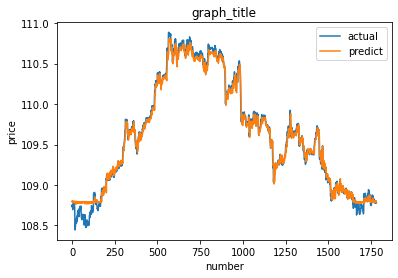

In [5]:
# USDJPY15分足
read_dir = "./OANDA_USDJPY, 15.csv"
df, X_train, n_inputs = data()
graph_title = '15m'
X_scarar_dir = './dump/USDJPY_15m_dump_turning_close_demo/X_train_scaler.sav'
y_scarar_dir = './dump/USDJPY_15m_dump_turning_close_demo/y_train_scaler.sav'
model_dir = './model/USDJPY_15m_turning_close_demo/model.hdf5'
param_dir = './model/USDJPY_15m_turning_close_demo/param.hdf5'
y_pred_1h, y_pred, y_train = learn(df, X_train, 'y_rate', 'graph_title', epochs, model_dir,param_dir, X_scarar_dir, y_scarar_dir) # 学習関数
#exit()